In [1]:
! pip install pandas-ta

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas-ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=445a35a5510bad96b5b1ca6030dcafbc4aeade9835c4a020693c77ace941c52a
  Stored in directory: /root/.cache/pip/wheels/69/00/ac/f7fa862c34b0e2ef320175100c233377b4c558944f12474cf0
Successfully built pandas-ta


In [2]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import pandas_ta as ta
from sklearn.preprocessing import MinMaxScaler

In [5]:
df1 = pd.read_csv('merged_technology_news_data_future_3months.csv')
df2 = pd.read_csv('technology_news_data_50Daily.csv')
df3 = pd.read_csv('1201-1210_news_data.csv')

# Combine the dataframes by row
df_combined = pd.concat([df1, df2, df3], ignore_index=True)
df_combined = df_combined.sort_values(by='time_published', ascending=True).reset_index(drop=True)

# Optional: Save the combined dataframe to a new CSV file
df_combined.to_csv('combined_file.csv', index=False)
display(df_combined)

,title,url,time_published,source,overall_sentiment_score,overall_sentiment_label,ticker_sentiment
0,CNH Industrial: Periodic Report on $300 Millio...,https://www.globenewswire.com/news-release/202...,2023-09-01 20:30:00,GlobeNewswire,0.312457,Somewhat-Bullish,"[{'ticker': 'RGBD', 'relevance_score': '0.0986..."
1,Sono Group Receives Additional Staff Determina...,https://www.globenewswire.com/news-release/202...,2023-09-01 20:30:00,GlobeNewswire,0.047543,Neutral,"[{'ticker': 'SEV', 'relevance_score': '0.10945..."
2,CytoSorbents Announces Resignation of Chief Fi...,https://www.globenewswire.com/news-release/202...,2023-09-01 20:43:00,GlobeNewswire,0.121210,Neutral,"[{'ticker': 'META', 'relevance_score': '0.0735..."
3,CytoSorbents Announces Resignation of Chief Fi...,https://www.benzinga.com/pressreleases/23/09/g...,2023-09-01 20:43:18,Benzinga,0.116318,Neutral,"[{'ticker': 'META', 'relevance_score': '0.0709..."
4,Positioning for a Year End Rally: 3 Top Ranked...,https://www.zacks.com/commentary/2143938/posit...,2023-09-01 20:45:00,Zacks Commentary,0.296182,Somewhat-Bullish,"[{'ticker': 'LRCX', 'relevance_score': '0.2589..."
...,...,...,...,...,...,...,...
23345,Google's New Willow Chip Accelerates Time to M...,https://decrypt.co/295678/googles-new-willow-c...,2024-12-09 23:34:55,Decrypt.co,0.079230,Neutral,"[{'ticker': 'MSFT', 'relevance_score': '0.0627..."
23346,"Five9, Inc. Shareholder Notice: Robbins LLP Re...",https://www.benzinga.com/pressreleases/24/12/g...,2024-12-09 23:50:42,Benzinga,0.053073,Neutral,"[{'ticker': 'FIVN', 'relevance_score': '0.5914..."
23347,"Five9, Inc. Shareholder Notice: Robbins LLP Re...",https://www.benzinga.com/pressreleases/24/12/g...,2024-12-09 23:50:42,Benzinga,0.053073,Neutral,"[{'ticker': 'FIVN', 'relevance_score': '0.5914..."
23348,Bitcoin and Ethereum ETFs Add Billions Amid Re...,https://decrypt.co/295733/bitcoin-and-ethereum...,2024-12-10 00:50:23,Decrypt.co,0.168180,Somewhat-Bullish,"[{'ticker': 'MSTR', 'relevance_score': '0.1529..."


In [6]:
def create_processed_data_df(start, end, ticker, sentiment_csv):
  stock_df = yf.download(ticker, start=start, end=end)
  stock_df = stock_df.xs(ticker, level='Ticker', axis=1)
  stock_df['time_published'] = stock_df.index
  stock_df['time_published'] = pd.to_datetime(stock_df['time_published'])
  stock_df['time_published'] = stock_df['time_published'].dt.date

  #Adding indicators
  stock_df['RSI']=ta.rsi(stock_df.Close, length=15)
  stock_df['EMAF']=ta.ema(stock_df.Close, length=20)
  stock_df['EMAM']=ta.ema(stock_df.Close, length=100)
  stock_df['EMAS']=ta.ema(stock_df.Close, length=150)
  display(stock_df)

  stock_df['Target'] = stock_df['Adj Close']-stock_df.Open
  stock_df['Target'] = stock_df['Target'].shift(-1)

  stock_df['TargetClass'] = [1 if stock_df.Target[i]>0 else 0 for i in range(len(stock_df))]

  stock_df['TargetNextClose'] = stock_df['Adj Close'].shift(-1)
  stock_df['TargetCloseIn2Days'] = stock_df['Adj Close'].shift(-2)
  stock_df['TargetCloseIn3Days'] = stock_df['Adj Close'].shift(-3)
  stock_df['TargetCloseIn4Days'] = stock_df['Adj Close'].shift(-4)
  stock_df['TargetCloseIn5Days'] = stock_df['Adj Close'].shift(-5)

  second_last_row = stock_df.iloc[[-2]]
  stock_df.dropna(inplace=True)
  stock_df.reset_index(inplace = True)
  stock_df = pd.concat([stock_df, second_last_row], ignore_index=True)
  stock_df.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)


  # stock_df_set = stock_df.iloc[:, 0:11]#.values
  # pd.set_option('display.max_columns', None)
  # display(stock_df)


  news_df = pd.read_csv(sentiment_csv)
  news_df['time_published'] = pd.to_datetime(news_df['time_published'])
  news_df['time_published'] = news_df['time_published'].dt.date
  news_df = news_df[news_df['title'] != 'Before you continue']


  df1 = stock_df.copy(deep=True)
  df2 = news_df[['time_published', 'source', 'overall_sentiment_score']]
  average_sentiment_df = df2.groupby(['time_published', 'source'], as_index=False)['overall_sentiment_score'].mean()
  average_sentiment_df.rename(columns={'overall_sentiment_score': 'average sentiment score'}, inplace=True)
  pivot_df = average_sentiment_df.pivot(index='time_published', columns='source', values='average sentiment score')
  pivot_df.reset_index(inplace=True)
  pivot_df.fillna(-1, inplace=True)
  pivot_df.replace(-1, np.nan, inplace=True)
  combined_df = pd.merge(df1, pivot_df, on='time_published', how='inner')
  # # combined_df['time_published'] = pd.to_datetime(combined_df['time_published'])
  # # combined_df['time_published'] = (combined_df['time_published'] - pd.to_datetime('1970-01-01')).dt.days
  # df_encoded = pd.get_dummies(combined_df, columns=['source'])
  # display(df_encoded)
  # display(combined_df)
  # List of columns representing sentiment scores
  news_sentiment_columns = combined_df.drop(['Adj Close', 'High', 'Low', 'Open', 'time_published', 'RSI', 'EMAF', 'EMAM', 'EMAS', 'Target', 'TargetClass', 'TargetNextClose', 'TargetCloseIn2Days', 'TargetCloseIn3Days', 'TargetCloseIn4Days', 'TargetCloseIn5Days'], axis=1).columns.tolist()

  # Calculate the mean sentiment across all news sources
  combined_df['aggregate_sentiment_mean'] = combined_df[news_sentiment_columns].mean(axis=1)

  # Calculate other possible aggregation metrics (optional)
  combined_df['aggregate_sentiment_median'] = combined_df[news_sentiment_columns].median(axis=1)
  combined_df['aggregate_sentiment_std'] = combined_df[news_sentiment_columns].std(axis=1)

  # Fill missing values with 0 before aggregation
  combined_df[news_sentiment_columns] = combined_df[news_sentiment_columns].fillna(0)

  # Recalculate the mean sentiment
  combined_df['aggregate_sentiment_mean'] = combined_df[news_sentiment_columns].mean(axis=1)

  second_last_row, second_last_row_date = combined_df.iloc[[-1]], combined_df.iloc[[-1]]['time_published'].values
  # combined_df = combined_df.iloc[:-1]

  # print(combined_df[['time_published', 'aggregate_sentiment_mean']].head())
  final_df = combined_df[['Adj Close', 'High', 'Low', 'Open', 'aggregate_sentiment_mean', 'aggregate_sentiment_median', 'aggregate_sentiment_std', 'Target', 'TargetClass', 'TargetNextClose', 'TargetCloseIn2Days', 'TargetCloseIn3Days', 'TargetCloseIn4Days', 'TargetCloseIn5Days']]
  time_published = combined_df['time_published'].values
  # final_df = combined_df[['Adj Close', 'High', 'Low', 'Open', 'Target', 'TargetClass', 'TargetNextClose']]


  data_set = final_df.iloc[:, 0:11]#.values
  pd.set_option('display.max_columns', None)

  return final_df, time_published, (second_last_row, second_last_row_date)

In [8]:
final_df, time_published, (second_last_row, second_last_row_date) = create_processed_data_df("2023-09-01", "2024-12-10", "QQQ", 'combined_file.csv')
# spy = yf.Ticker("SPY")
display(final_df)

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume,time_published,RSI,EMAF,EMAM,EMAS
Date,,,,,,,,,,,
2023-09-01,374.475830,377.589996,380.829987,376.079987,380.399994,39772400,2023-09-01,NaN,NaN,NaN,NaN
2023-09-05,374.951935,378.070007,379.309998,375.829987,376.769989,32344200,2023-09-05,NaN,NaN,NaN,NaN
2023-09-06,371.649353,374.739990,377.630005,372.700012,377.279999,42998700,2023-09-06,NaN,NaN,NaN,NaN
2023-09-07,368.991486,372.059998,372.850006,369.149994,370.209991,52060700,2023-09-07,NaN,NaN,NaN,NaN
2023-09-08,369.507202,372.579987,374.850006,371.600006,372.010010,35800100,2023-09-08,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-03,516.869995,516.869995,517.150024,513.369995,513.950012,18597900,2024-12-03,64.044899,506.060371,485.863898,474.718866
2024-12-04,523.260010,523.260010,523.520020,519.599976,520.320007,26086200,2024-12-04,68.222767,507.698432,486.604415,475.361795
2024-12-05,521.809998,521.809998,524.039978,521.419983,523.309998,18169600,2024-12-05,66.348388,509.042390,487.301555,475.977003


<ipython-input-6-56599fc9c50f>:18: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  stock_df['TargetClass'] = [1 if stock_df.Target[i]>0 else 0 for i in range(len(stock_df))]


,Adj Close,High,Low,Open,aggregate_sentiment_mean,aggregate_sentiment_median,aggregate_sentiment_std,Target,TargetClass,TargetNextClose,TargetCloseIn2Days,TargetCloseIn3Days,TargetCloseIn4Days,TargetCloseIn5Days
0,439.283508,442.500000,439.200012,441.410004,0.056476,0.162014,0.108029,-2.051361,0,440.908630,437.060181,444.039246,436.960449,429.772003
1,440.908630,443.239990,437.440002,442.959991,0.056175,0.143970,0.139817,0.060181,1,437.060181,444.039246,436.960449,429.772003,429.811890
2,437.060181,439.239990,436.279999,437.000000,0.037851,0.162568,0.107070,3.779236,1,444.039246,436.960449,429.772003,429.811890,424.567596
3,444.039246,446.329987,437.959991,440.260010,0.030058,0.121310,0.125926,-4.139557,0,436.960449,429.772003,429.811890,424.567596,422.144867
4,436.960449,442.239990,436.880005,441.100006,0.049813,0.162524,0.070360,-12.287994,0,429.772003,429.811890,424.567596,422.144867,413.411041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,509.309998,510.140015,507.230011,508.079987,0.020275,0.199097,0.051267,-2.870026,0,505.299988,509.739990,515.289978,516.869995,523.260010
163,505.299988,508.239990,501.929993,508.170013,0.022794,0.193262,0.174795,3.809998,1,509.739990,515.289978,516.869995,523.260010,521.809998
164,509.739990,510.339996,505.309998,505.929993,0.021894,0.176974,0.061483,4.279968,1,515.289978,516.869995,523.260010,521.809998,526.479980
165,515.289978,516.260010,510.619995,511.010010,0.023133,0.221688,0.165670,2.919983,1,516.869995,523.260010,521.809998,526.479980,522.380005


In [9]:
display(second_last_row)

,Adj Close,High,Low,Open,time_published,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose,TargetCloseIn2Days,TargetCloseIn3Days,TargetCloseIn4Days,TargetCloseIn5Days,Al Jareeza,Associated Press,Barrons,Benzinga,Business Insider,Business Standard,CNBC,CNN,Canada Newswire,Cointelegraph,Decrypt.co,Financial News London,Financial Times,Forbes,Fox Business News,GlobeNewswire,Investing News Network,Investor Ideas,Investors Business Daily,Kiplinger,MarketWatch,Money Control,Money Morning,Motley Fool,New York Times,PR Newswire,PennyStocks.com,Reuters,South China Morning Post,StockMarket.com,Stocknews.com,The Atlantic,The Economist,The Financial Express,The Street,The Week News,UPI Business,Wall Street Journal,Zacks Commentary,aggregate_sentiment_mean,aggregate_sentiment_median,aggregate_sentiment_std
166,526.47998,526.719971,522.349976,522.47998,2024-12-06,69.262484,510.703113,488.077365,476.645916,-3.140015,0,522.380005,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.197643,0.0,0.0,0.114069,0.0,0.0,0.0,0.172797,0.0,0.0,0.0,0.0,0.209261,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.311098,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.274591,0.032807,0.203452,0.070809


In [10]:
def create_scaled_dataset(df,  time_published, MinMaxScaler=MinMaxScaler, backcandles=30):
  sc = MinMaxScaler(feature_range=(0,1))
  # data_set_scaled = sc.fit_transform(data_set)
  # print(data_set_scaled)
  data_set = df.to_numpy()
  # multiple feature from data provided to the model
  X = []
  corresponding_times = []
  print(data_set.shape[0])
  for j in range(8):#data_set_scaled[0].size):#2 columns are target not X
      X.append([])
      for i in range(backcandles, data_set.shape[0]):#backcandles+2
          X[j].append(data_set[i-backcandles:i, j])

  for i in range(backcandles, data_set.shape[0]):  # Starting from backcandles to get the correct times
    # Append the time corresponding to the last time step of each sample
    corresponding_times.append(time_published[i])
  corresponding_times = np.array(corresponding_times)


  #move axis from 0 to position 2
  X=np.moveaxis(X, [0], [2])

  #Erase first elements of y because of backcandles to match X length
  X, yi =np.array(X), np.array(data_set[backcandles:,-5:])
  y=np.reshape(yi,(len(yi),5))
  # print(X)
  print(X.shape)
  # print(y)
  print(y.shape)

  from sklearn.preprocessing import MinMaxScaler
  sc_X = MinMaxScaler(feature_range=(0, 1))
  sc_y = MinMaxScaler(feature_range=(0, 1))

  X_shape = X.shape
  X_reshaped = X.reshape(-1, X.shape[2])

  X_reshaped_scaled = sc_X.fit_transform(X_reshaped)
  X = X_reshaped_scaled.reshape(X_shape[0], X_shape[1], -1)
  y = sc_y.fit_transform(y)
  return X, y, sc_X, sc_y, corresponding_times

In [11]:
X, y, sc_X, sc_y, corresponding_times = create_scaled_dataset(final_df, time_published, MinMaxScaler)
last_X, last_y, last_time = X[-1], y[-1], corresponding_times[-1]
X, y, corresponding_times = X[:-1, :, :], y[:-1], corresponding_times[:-1]
print(X.shape, y.shape)

167
(137, 30, 8)
(137, 5)
(136, 30, 8) (136, 5)


In [15]:
# split data into train test sets
splitlimit = 92
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]
time_published_train, time_published_test = corresponding_times[:splitlimit], corresponding_times[splitlimit:]
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)
print(sc_y.inverse_transform([y_train[-1]]), time_published_train[-1])
print(sc_y.inverse_transform([y_test[-1]]), time_published_test[-1])
# print(y_train)

92
(92, 30, 8) (44, 30, 8)
(92, 5) (44, 5)
[[481.26998901 481.95001221 481.58999634 487.32000732 482.1000061 ]] 2024-09-30
[[516.86999512 523.26000977 521.80999756 526.47998047 522.38000488]] 2024-12-02


In [11]:
# test_df, time_published_test = create_processed_data_df('2023-09-01', '2024-11-01', 'QQQ', 'combined_file.csv')

# X_test, y_test, sc_X_test, sc_y_test, time_published_test = create_scaled_dataset(test_df, time_published_test)
# display(time_published_test)
# # Filter test_df to only include rows with time_published > '2024-09-01'
# test_df = test_df.loc[time_published_test  > pd.to_datetime('2024-09-01')]

# # Apply the same filter to the other DataFrames using the same index from filtered test_df
# X_test = X_test.loc[test_df.index]
# y_test = y_test.loc[test_df.index]
# sc_X_test = sc_X_test.loc[test_df.index]
# sc_y_test = sc_y_test.loc[test_df.index]
# time_published_test = time_published_test.loc[test_df.index]

In [16]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np

np.random.seed(506)
backcandles = 30

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(5, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - loss: 0.1393 - val_loss: 0.0065
Epoch 2/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0428 - val_loss: 0.0442
Epoch 3/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0278 - val_loss: 0.0586
Epoch 4/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0299 - val_loss: 0.0272
Epoch 5/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0208 - val_loss: 0.0151
Epoch 6/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0180 - val_loss: 0.0244
Epoch 7/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0178 - val_loss: 0.0341
Epoch 8/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0203 - val_loss: 0.0302
Epoch 9/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0185 - val_loss: 0.0212
Epoch 10/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0182 - val_loss: 0.0227
Epoch 11/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0173 - val_loss: 0.0255
Epoch 12/30
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0183 - val_loss: 0.0342
E

In [17]:
loss = model.evaluate(X_test, y_test, verbose=0)
print(f"Mean Squared Error on test set: {loss}")
y_pred = model.predict(X_test)

Mean Squared Error on test set: 0.11695951968431473
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step


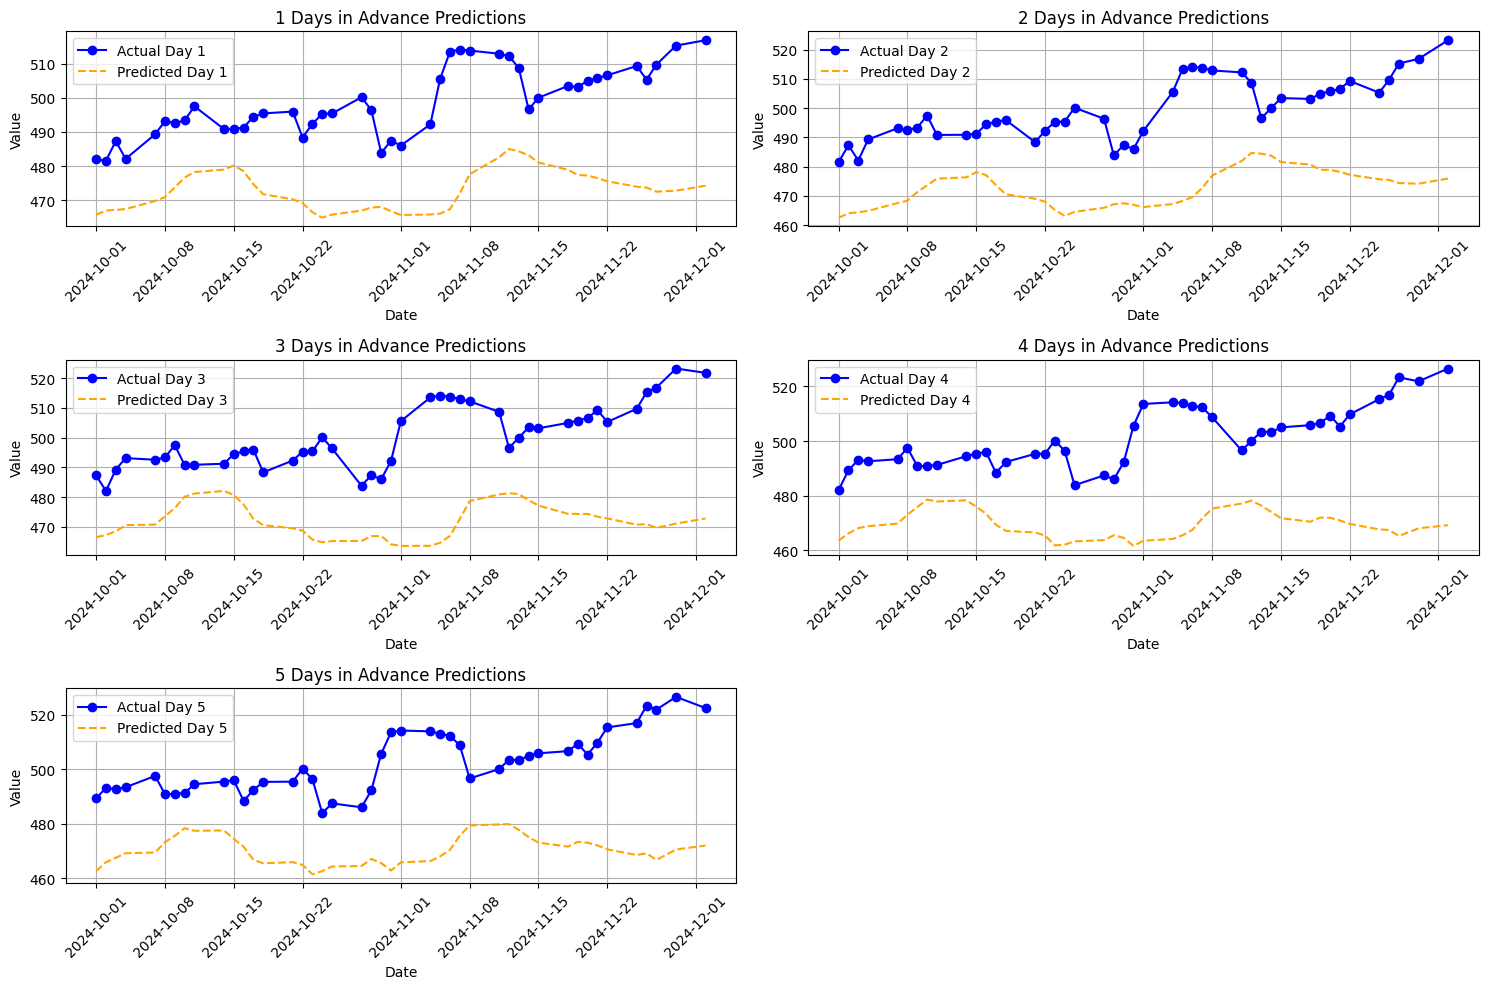

In [18]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming test_dates are the dates corresponding to X_test
num_days = 5  # Number of days ahead predictions
test_dates = pd.DataFrame(time_published_test)  # Example dates

y_test_original = sc_y.inverse_transform(y_test)
y_pred_original = sc_y.inverse_transform(y_pred)

# Create DataFrames for easier handling
y_test_df = pd.DataFrame(y_test_original, index=test_dates, columns=[f"Day {i+1}" for i in range(num_days)])
y_pred_df = pd.DataFrame(y_pred_original, index=test_dates, columns=[f"Day {i+1}" for i in range(num_days)])

# Plot each day individually
plt.figure(figsize=(15, 10))

for i in range(num_days):
    plt.subplot(3, 2, i + 1)  # Create a grid of 3 rows, 2 columns
    plt.xticks(rotation=45)
    plt.plot(test_dates, y_test_df.iloc[:, i], label=f"Actual Day {i+1}", color="blue", linestyle="-", marker="o")
    plt.plot(test_dates, y_pred_df.iloc[:, i], label=f"Predicted Day {i+1}", color="orange", linestyle="--")
    plt.title(f"{i+1} Days in Advance Predictions")
    plt.xlabel("Date")
    plt.ylabel("Value")
    plt.legend()
    plt.grid()

# Adjust layout and show the plots
plt.tight_layout()
plt.show()


[datetime.datetime(2024, 12, 9, 0, 0)
 datetime.datetime(2024, 12, 10, 0, 0)
 datetime.datetime(2024, 12, 11, 0, 0)
 datetime.datetime(2024, 12, 12, 0, 0)
 datetime.datetime(2024, 12, 13, 0, 0)]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
[[476.78802 477.44604 475.86288 472.41644 474.89133]]


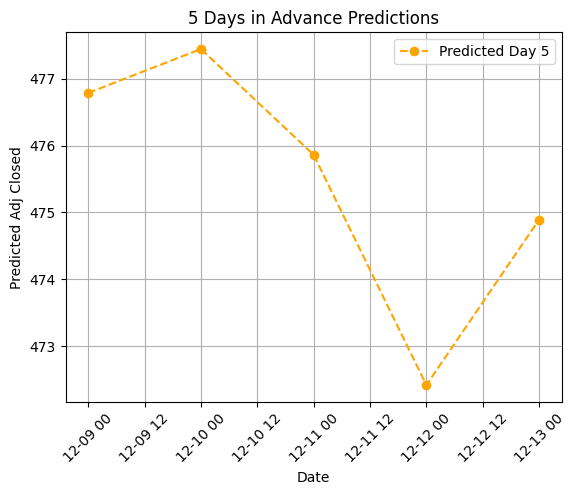

In [27]:
from datetime import datetime, timedelta

start_date = datetime(2024, 12, 9)
end_date = datetime(2024, 12, 13)

datetime_list = [start_date + timedelta(days=i) for i in range((end_date - start_date).days + 1)]

future_dates = np.array(datetime_list)

print(future_dates)
last_y_pred = model.predict(last_X.reshape(1, 30, 8))
last_y_pred_original = sc_y.inverse_transform(last_y_pred)
print(last_y_pred_original)

plt.xticks(rotation=45)
plt.plot(future_dates, last_y_pred_original.reshape(5,), label=f"Predicted Day {i+1}", color="orange", linestyle="--", marker="o")
plt.title(f"{i+1} Days in Advance Predictions")
plt.xlabel("Date")
plt.ylabel("Predicted Adj Closed")
plt.legend()
plt.grid()